# A Closer look at Fama-MacBeth (1973)

In this exercise, let's go through an early test of CAPM - Fama and MacBeth's (1973) study on cross-sectional returns. Specifically, we're interested in estimating the market risk premium - i.e. does the market reward taking on risk with higher expected returns (C3 in Fama-MacBeth)?

## Motivation

The model we have been studying is an expected return-beta model, or in other words a model of the form:

$$R_i = \alpha_i + \beta_i E(f)$$

That is the returns of an asset are a function of some universal factor $f$, scaled by $\beta$, the individual stock's sensitivity to changes in that factor, with some unexplainable part $\alpha$ that we expect to be equal to zero. CAPM suggests the sole factor that determines the return on the asset is the market excess return, so that

$$R_i = \alpha_i + \beta_i MKT$$

### So why can't we just use OLS to estimate this equation?

There are two problems with this approach that violate the usual OLS assumptions. 

1. Normally, we expect our covariates to be fixed-point constants, not random variables. However, since the $\beta$'s are outcomes of a statistical model, they themselves are random variables, so this assumption is violated (these are called *generated regressors*). The use of generated regressors does not affect the coefficient estimates, but does cause the standard errors to be under-estimated, so hypothesis testing is invalid. 

2. More seriously, the $\alpha$'s are significantly correlated across assets via industry effects. If Microsoft got lucky this period, it's likely that Google also got lucky in the same period. This is a big problem for cross-sectional regressions because the $\alpha$'s are actually our error terms, and one important assumption for OLS is that the error terms are i.i.d. Since this isn't the case, OLS cannot apply to the equation above. 

### Estimating cross-sectional returns

The market factor is the same for all stocks $i$ at each individual time period $t$, so the hypothesis that CAPM suggests is that higher $\beta$ should result in higher returns given a cross-section of individual assets! These betas can be estimated in the usual way with time-series regressions as we've already seen. For each individual stock $i$, we can estimate:

$$R_{i,t} = \alpha_{i,t} + \hat{\beta} MKT_t + \varepsilon_{i,t}$$

Then collect the betas and use them for estimation of future returns.

### Estimating the average risk premium

We should expect to be able to run this across a large cross section of stocks and observe the relationship between beta and the expected return of an individual asset. That is, we should be able to discover how sensitive asset returns are to their individual beta's with a regression like:

$$E(R_i) = (\gamma_i) + \lambda \beta_i + \alpha_i$$

Notice this reduces to CAPM when $\lambda = MKT$ - something we can check in the analysis. This carries the crucial advantage of eliminating the cross-sectional correlation in the $\alpha$'s by dispersing the correlation throughout the sample in the first regression. Neat!

We can run this regression and test the hypothesis that $\lambda > 0$, or that higher beta's should be associated with higher expected returns on a stock (or portfolio of stocks), in order to get some idea of how the market is pricing in risk. ($\gamma_i$ is included in parentheses here to indicate that one can include a constant in this regression or not. The reason is that $\beta = 0$ implies a riskless asset. We've already factored in the risk free rate when we calculated excess returns, so this intercept should be zero.)

Econometrically speaking, that gives us a task - we need to estimate the parameters $\hat{\alpha}$, $\hat{\beta}$, and $\hat{\lambda}$, along with the standard errors $\sigma(\hat{\alpha})$, $\sigma(\hat{\beta})$, and $\sigma(\hat{\lambda})$.

In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Let's start by setting up a simulated market environment to explore this model. We'll set the risk-free rate of return to 1\%, and simulate data for 2000 firms over 2520 (approximately 10 years of trading days worth of returns).

In [2]:
#Declare parameters and constants
rf = 0.01
N = 2000
T = 2520 #Approx 10 years of trading days
dt = 1/252 #length of a single time unit to calculate daily returns
s = np.sqrt(0.5*dt)

Next let's simulate a set of betas for all 2000 stocks, and a market excess factor (`mkt`) for each day of our simualted market. Lastly we'll use the betas and our market factor to generate simulated "true" returns for our stocks over the period. Note that I'm assuming an average market return of 6\%. Since we're using daily returns, I have to multiply this by `dt`. This gets us the first term in `mkt`. The second is just a generated error around this trend.

In [3]:
#Create simulated market returns
beta_true = np.random.normal(1, 0.25, (N, 1)) #create true betas
mkt = 0.06*dt + np.random.standard_normal((T, 1)) #market excess factor

#Calculate market returns data
data= rf*dt + np.transpose(beta_true) * mkt + s*np.random.standard_normal((T, N))

-0.02557206911724391

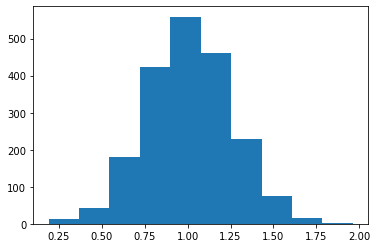

In [4]:
#plot histogram of generated betas
plt.hist(beta_true)
np.mean(mkt)

Let's pick one stock from our simulated data and take a look just to make sure everything's behaving well. Here we grab stock \#21 from our portfolio and plot the returns over time. 

In [5]:
y = data[:, 20] #pick data for one stock to test

Now let's do a sanity check by regressing the market excess factor onto the simulated returns to estimate a beta (like we did before). Here we're using `sklearn` to do the regression (You can use statsmodels if you want instead).

In [6]:
model = LinearRegression()
model.fit(mkt, y)

print(f'Intercept: {model.intercept_}')
print(f'Estimated beta: {model.coef_[0]}')
print(f'True beta: {beta_true[20][0]}')

Intercept: -0.0019394713377994602
Estimated beta: 1.3681158031166554
True beta: 1.3664121922303885


Good news! Our estimated beta is very close to the true beta, so the simulated data makes sense.

Now let's start on the Fama-MacBeth procedure. There are two steps to Fama-MacBeth regressions: (1) we need to do time series regressions to obtain estimated betas for every firm, and (2) we need to regress the individual cross sections at each time period on the estimated beta's to estimate the slope of the efficient frontier.

First we'll need to estimate betas for all 2000 firms in our sample. (And yes, that means we'll need to do 2000 regressions)

In [315]:
#Set up array of results
b = []

#Loop through data and gather coefficients
for i in range(N):
    y = data[:, i]
    model = LinearRegression()
    model.fit(mkt, y)
    b.append(model.coef_[0])

(array([ 11.,  39., 139., 315., 513., 487., 315., 136.,  37.,   8.]),
 array([0.18235127, 0.34579623, 0.50924119, 0.67268615, 0.8361311 ,
        0.99957606, 1.16302102, 1.32646598, 1.48991094, 1.6533559 ,
        1.81680086]),
 <BarContainer object of 10 artists>)

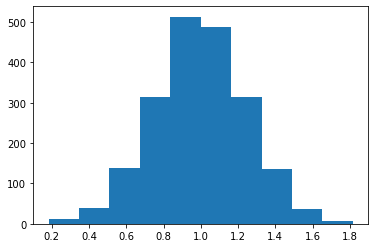

In [316]:
#Histogram of estimated beta coefficients
plt.hist(b)

Now that we have our betas, let's do step 2 - the cross sectional regressions. Once again, we'll need to do cross sectional regressions of all the stock returns each period on the betas of the stocks

In [317]:
b = np.array(b)
b=b.reshape(-1,1)

res = []

for i in range(T):
    y = data[i, :]
    model = LinearRegression()
    model.fit(b, y)
    res.append(model.coef_[0])

In [318]:
df = pd.DataFrame(res)
df.describe()

,0
count,2520.000000
mean,0.025641
std,1.025101
min,-3.467214
25%,-0.682629
50%,0.017422
75%,0.708741
max,3.501259


By taking the average of the $\lambda$'s across the whole sample, we can get an idea of the market risk premium (i.e. how much the market compensates investors for taking on additional risk). Notice that our mean risk premium is almost equal to the average of the market excess factor (Exactly as Sharpe/Lintner predicted!!). 

In [319]:
print('Mean risk premium: ', df.mean())
print('Mean market factor return: ', np.mean(mkt))

Mean risk premium:  0    0.025641
dtype: float64
Mean market factor return:  0.025683944074620466


We can do traditional hypothesis testing and see if our results make sense. The p-value of 0.1 indicates the risk premium we found is significant at the 10% level. 

(Other rolls of this notebook suggested varying degrees of statistical significance - this is largely a function of how I set up the daily variation, but largely replicates the original Fama-MacBeth findings - many of their regressions were barely significant or not at all)

In [320]:
se = df.std()/np.sqrt(T)
t_score = df.mean()/se

In [321]:
from scipy.stats import t
p_value = t.sf(t_score, T)[0]
p_value

0.10467850913894938

## Conclusion

Fama-MacBeth (1973) is a seminal paper in the field of asset pricing, and all who go into the industry should have a good working knowledge of how it is done. 

Since then there have been many improvements on this paper. For one, it tends to produce market risk premia that are "too low", i.e. that the premium offered does not match what we would expect reasonably risk averse investors to be willing to accept. Lastly, It can be shown that the market return factor by itself is not sufficient to explain all of the variation in stock portfolios. A significant variation can also be explained in small vs. large stocks, and growth vs value stocks (Malkiel references this a number of times). 

These findings have produced a ton of research and led to the very popular Fama-French models of the 1990s which include factors other than the market factor. We'll be exploring those models next!